In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time 
import os
import copy
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix

In [0]:
# !unzip -q "/content/drive/My Drive/A_05_Part_02_Dataset.zip" -d "data"

In [0]:
# !unzip '/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2_data/A_05_Part_02_Dataset.zip'
# !unzip '/content/drive/My Drive/A_05_Part_02_Dataset.zip'

In [0]:
data_dir = '/content/drive/My Drive/Data/dl_assignment5_part2_data/A_05_Part_02_Dataset'

In [0]:
 #Define transforms for the training data and testing data
 batchSize = 16
train_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batchSize, shuffle=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=batchSize, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batchSize, shuffle=True, num_workers=4)

In [10]:
print('Train: ', len(train_data))
print('Validation: ', len(validation_data))
print('Test: ', len(test_data))

Train:  6200
Validation:  628
Test:  629


In [0]:
class FocalLoss(nn.Module):
  def __init__(self, alpha=1, gamma=1):
    super(FocalLoss, self).__init__()
    self.alpha = alpha
    self.gamma = gamma

  def forward(self, outputs, targets):
    loss = nn.functional.binary_cross_entropy_with_logits(outputs, targets, reduce=False)
    pt = torch.exp(-loss)
    loss = self.alpha * loss
    return torch.mean(loss)

In [0]:
def confusionMatrix(model, loader):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  confusion_matrix = torch.zeros(3, 3)
  model.to(device)
  t = np.array([
       [[0,  0],
        [ 0,  0]],

       [[ 0,  0],
        [ 0,  0]],

       [[ 0,  1],
        [ 0,  0]]])
  with torch.no_grad():
    for i, (inputs, classes) in enumerate(loader):
      inputs = inputs.to(device)
      classes = classes.to(device)
      outputs = model(inputs)
      outputs = torch.round(torch.sigmoid(outputs))
      newLabels = torch.zeros(len(classes), 3, dtype=torch.long)
      for i in range(len(classes)):
        if classes[i]  == 0:
          newLabels[i] = torch.LongTensor([1, 0, 1])
        elif classes[i]  == 1:
          newLabels[i]  = torch.LongTensor([0, 1, 0])
        elif classes[i]  == 2:
          newLabels[i]  = torch.LongTensor([0, 0, 1])
      classes = newLabels.type_as(outputs)
      # t = newLabels.type_as(outputs)
      classes, outputs = classes.to('cpu'), outputs.to('cpu')
      # print(i-16:i)
      # t[i-16:i] = classes
      # print(i, i+8)
      # print(t[i:i+8][:])
      t +=  multilabel_confusion_matrix(classes, outputs)
    return t

#       # covidLabel = torch.Tensor([1, 0, 1]).to(device)
#       # normalLabel = torch.Tensor([0, 1, 0]).to(device)
#       # pnumuniaLabel = torch.Tensor([0, 0, 1]).to(device)

#       # for t, p in zip(classes, outputs):
#       #   if (t == covidLabel).all() :#covid
#       #     if (p == covidLabel).all() :#covid
#       #       confusion_matrix[0, 0] += 1
#       #     elif (p == normalLabel).all():#normal
#       #       confusion_matrix[0, 1] += 1
#       #     elif (p == pnumuniaLabel).all():#pnumunia
#       #       confusion_matrix[0, 2] += 1
#       #   elif (t == normalLabel).all():#normal
#       #     if (p == covidLabel).all() :#covid
#       #       confusion_matrix[1, 0] += 1
#       #     elif (p == normalLabel).all():#normal
#       #       confusion_matrix[1, 1] += 1
#       #     elif (p == pnumuniaLabel).all():#pnumunia
#       #       confusion_matrix[1, 2] += 1
#       #   elif (t == pnumuniaLabel).all():#pnumunia
#       #     if (p == covidLabel).all() :#covid
#       #       confusion_matrix[2, 0] += 1
#       #     elif (p == normalLabel).all():#normal
#       #       confusion_matrix[2, 1] += 1
#       #     elif (p == pnumuniaLabel).all():#pnumunia
#       #       confusion_matrix[2, 2] += 1
#   # return confusion_matrix.int()

In [0]:
def printResult(model, trainloader, testloader, batchSize):
  trainConfusion = confusionMatrix(model, trainloader)
  testConfusion = confusionMatrix(model, testloader)
  score = fOneScore(torch.Tensor([[ 147, 7, 42],[0, 3780,  167],[4,238, 1719]]))
  testingAccuracy = accuracy(model, testloader, batchSize)
  trainingAccuracy = accuracy(model, trainloader, batchSize)
  print("Train Confusion Matrix :",  trainConfusion)
  print("Validation Confusion Matrix :", testConfusion)
  print("F1 Score: ", score)
  print('Train Accuracy: ', trainingAccuracy)
  print('Validation Accuracy: ', testingAccuracy)

In [0]:
def fOneScore(confusionMatrix):
  sum0Axis = confusionMatrix.sum(axis=0)
  sum1Axis = confusionMatrix.sum(axis=1)
  p, r = 0, 0
  for i in range(len(confusionMatrix)):
    p += confusionMatrix[i][i]/sum0Axis[i]
    r += confusionMatrix[i][i]/sum1Axis[i]
  p, r = p/len(confusionMatrix), r/len(confusionMatrix)
  return 2 * (p * r)/ (p + r)


In [0]:
def accuracy(model, loader, batchSize): 
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  confusion_matrix = torch.zeros(3, 3)
  acctemp = 0
  total = 0
  correct = 0
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(loader):

      newLabels = torch.zeros(len(labels), 3, dtype=torch.long)
      for i in range(len(labels)):
        if labels[i]  == 0:
          newLabels[i] = torch.LongTensor([1, 0, 1])
        elif labels[i]  == 1:
          newLabels[i]  = torch.LongTensor([0, 1, 0])
        elif labels[i]  == 2:
          newLabels[i]  = torch.LongTensor([0, 0, 1])

      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      labels = newLabels.type_as(outputs)

      outputs = torch.round(torch.sigmoid(outputs))
      total += labels.size(0)
      correct += ((outputs == labels).all(axis=1)).sum().item()
      acctemp += 100 * correct / total
  return acctemp/(len(loader.dataset)/batchSize)

In [0]:
def train(model, lr,epochs, l1, l2, criterionParam, optimParam, batchSize,trainacc, validationacc, trainloss, validationloss, alpha = torch.Tensor([0.6, 0.2, 0.2]), gamma=1.5):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  if criterionParam == "BCE": #Binary Cross Entropy Loss with logits
    criterion = nn.BCEWithLogitsLoss()
  elif criterionParam == "FL":  #Focal Loss
    criterion = FocalLoss(alpha.to(device), gamma)
  else:
    raise Exception('Exception: Criterion parameter Not passed')

  if optimParam == "SGD": #Stocastic Gradient Descent
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
  elif optimParam == "Adam":
    optimizer = optim.Adam(model.parameters())
  else:
    raise Exception('Exception: Optimzer parameter Not passed')

  
  model.to(device)
  model.train()
  for epoch in range(epochs):  
    running_loss, trainacctemp, validationacctemp, testingacctemp, trainlosstemp, validationlosstemp, correct, total = 0.0, 0, 0, 0, 0, 0, 0, 0
    pbar = tqdm(enumerate(l1))
    for i, data in pbar:
      #train
      inputs, labels = data

      #convert categorical labels to binary 0 -> [1, 0, 1](covid) : 0 -> [0, 1, 0](normal) : 0 -> [0, 0, 1](Pneumonia)
      newLabels = torch.zeros(len(labels), 3, dtype=torch.long)
      for i in range(len(labels)):
        if labels[i]  == 0:
          newLabels[i] = torch.LongTensor([1, 0, 1])
        elif labels[i]  == 1:
          newLabels[i]  = torch.LongTensor([0, 1, 0])
        elif labels[i]  == 2:
          newLabels[i]  = torch.LongTensor([0, 0, 1])

      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      labels = newLabels.type_as(outputs)

      loss = criterion(outputs, labels)   #----> compute loss
      loss.backward()                     #----> backward pass
      optimizer.step()                    #----> weights update


      #accuracy
      outputs = torch.round(torch.sigmoid(outputs))
      total += labels.size(0)
      correct += ((outputs == labels).all(axis=1)).sum().item()
      trainacctemp += 100 * correct / total


      trainlosstemp += loss.item()
      # print('\rEpoch: ', epoch, ' item: ', i * len(inputs), ' total item: ', len(l1.dataset), end='')
      inputs, labels = inputs.to('cpu'), labels.to('cpu')

    #validation
    with torch.no_grad():
      correct = 0
      total = 0
      pbar = tqdm(enumerate(l2))
      for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        newLabels = torch.zeros(len(labels), 3, dtype=torch.long)
        for i in range(len(labels)):
          if labels[i]  == 0:
            newLabels[i] = torch.LongTensor([1, 0, 1])
          elif labels[i]  == 1:
            newLabels[i]  = torch.LongTensor([0, 1, 0])
          elif labels[i]  == 2:
            newLabels[i]  = torch.LongTensor([0, 0, 1])

        outputs = model(inputs)
        labels = newLabels.type_as(outputs)

        loss = criterion(outputs, labels)   #----> compute loss
        validationlosstemp += loss.item()

        outputs = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += ((outputs == labels).all(axis=1)).sum().item()
        validationacctemp += 100 * correct / total

        # print('\rEpoch: ', epoch, ' item: ', i * len(inputs), ' total item: ', len(l2.dataset), end='')
    tacc = trainacctemp/(len(l1.dataset)/batchSize)
    vacc = validationacctemp/(len(l2.dataset)/batchSize)

    tloss = trainlosstemp/(len(l1.dataset)/batchSize)
    vloss = validationlosstemp/(len(l2.dataset)/batchSize)
    trainacc.append(tacc)
    trainloss.append(tloss)
    validationacc.append(vacc)
    validationloss.append(vloss)
    print('\rEpoch: ', epoch, '\tTraining accuracy: ', tacc, '\tValidation accuracy: ', vacc, '\tTraining loss: ', tloss, '\tValidation loss: ', vloss)
  return trainacc, validationacc, trainloss, validationloss, model

In [0]:
def plotResults(trainacc, validationacc, trainloss, validationloss):
  plt.plot(trainacc, label = 'Training accuracy')
  plt.plot(validationacc, label = 'Validation accuracy')
  plt.legend()
  plt.show()
  plt.plot(trainloss, label = 'Training loss') 
  plt.plot(validationloss, label = 'Validation loss')
  plt.legend()
  plt.show()

In [0]:
def predict(model, loader, batchSize): 
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  acctemp = 0
  total = 0
  correct = 0
  predictions = []
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(loader):
      j=0
      inputs = inputs.to(device)
      outputs = model(inputs)
      outputs = torch.round(torch.sigmoid(outputs))
      outputs = outputs.to('cpu')
      for out in outputs:
        out = out.numpy()
        predictions.append([testloader.dataset.imgs[i+j][0][86:-4], out[0].astype(int), out[2].astype(int), out[1].astype(int)])
        j += 1
    return predictions

Experiment 1:


In [0]:
vgg16_1 = models.vgg16(pretrained=True)
for parm in vgg16_1.parameters():
  parm.requires_grad = False

num_features = vgg16_1.classifier[0].in_features
vgg16_1.classifier = vgg16_1.classifier[:4]
vgg16_1.classifier[0] = nn.Linear(num_features, 510)
vgg16_1.classifier[3] = nn.Linear(510, 3)
vgg16_1.load_state_dict(torch.load('/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/vgg16_experiment1', map_location=device))
trainacc_vgg_fc, validationacc_vgg_fc, trainloss_vgg_fc, validationloss_vgg_fc = [], [], [], []

In [0]:
trainacc_vgg_fc, validationacc_vgg_fc, trainloss_vgg_fc, validationloss_vgg_fc, vgg16_1 = train(vgg16_1, 0.00005, 20, trainloader, validationloader, "BCE", "SGD", batchSize ,trainacc_vgg_fc, validationacc_vgg_fc, trainloss_vgg_fc, validationloss_vgg_fc)


Epoch:  0 	Training accuracy:  58.25243968869166 	Validation accuracy:  80.05649021814142 	Training loss:  0.4091140417898855 	Validation loss:  0.3438053605662789



Epoch:  1 	Training accuracy:  78.97805479782292 	Validation accuracy:  83.76746394705556 	Training loss:  0.3023624652047311 	Validation loss:  0.28537052338290364



Epoch:  2 	Training accuracy:  82.6989795911859 	Validation accuracy:  84.82267707279878 	Training loss:  0.26654303225778764 	Validation loss:  0.2648540894696667



Epoch:  3 	Training accuracy:  83.44868263063101 	Validation accuracy:  86.69361838968814 	Training loss:  0.24736828444465514 	Validation loss:  0.2486934859281892



Epoch:  4 	Training accuracy:  84.33241115153567 	Validation accuracy:  86.99473420011435 	Training loss:  0.233901257697613 	Validation loss:  0.2413148363684393



Epoch:  5 	Training accuracy:  84.67193093573864 	Validation accuracy:  87.29505095979782 	Training loss:  0.2246139027995448 	Validation loss:  0.2485496536561638



Epoch:  6 	Training accuracy:  84.85939125535523 	Validation accuracy:  89.95712719884085 	Training loss:  0.21544987158429238 	Validation loss:  0.22438898853435638



Epoch:  7 	Training accuracy:  86.52530497260055 	Validation accuracy:  88.3407754219733 	Training loss:  0.20602354115055455 	Validation loss:  0.21546005405438173



Epoch:  8 	Training accuracy:  86.84748665582612 	Validation accuracy:  88.61218368755551 	Training loss:  0.1999516031049913 	Validation loss:  0.21562730962303794



Epoch:  9 	Training accuracy:  87.41265491608048 	Validation accuracy:  87.98804164477063 	Training loss:  0.19379665244010186 	Validation loss:  0.2235422056571693



Epoch:  10 	Training accuracy:  87.41451083453555 	Validation accuracy:  86.24144278033647 	Training loss:  0.1891192288744834 	Validation loss:  0.21644585945044353



Epoch:  11 	Training accuracy:  88.31772994776311 	Validation accuracy:  89.49664285431689 	Training loss:  0.1855445389593801 	Validation loss:  0.20324885256730826



Epoch:  12 	Training accuracy:  88.15009305463407 	Validation accuracy:  88.00803242016053 	Training loss:  0.17864539151230166 	Validation loss:  0.1924975054089431



Epoch:  13 	Training accuracy:  88.68374298635734 	Validation accuracy:  89.99193741279778 	Training loss:  0.17445072234638276 	Validation loss:  0.20194484378881516



Epoch:  14 	Training accuracy:  88.70111735624745 	Validation accuracy:  90.07422875171017 	Training loss:  0.1723015898610315 	Validation loss:  0.20754328996512542



Epoch:  15 	Training accuracy:  89.20268406040346 	Validation accuracy:  89.59298914356386 	Training loss:  0.16787492087291134 	Validation loss:  0.19875837340476407



Epoch:  16 	Training accuracy:  89.68663260712677 	Validation accuracy:  86.72928208377843 	Training loss:  0.16553414434194566 	Validation loss:  0.19292072847390632



Epoch:  17 	Training accuracy:  89.59251808589308 	Validation accuracy:  90.74196795997568 	Training loss:  0.16295105122750805 	Validation loss:  0.18815511939631904



Epoch:  18 	Training accuracy:  90.0425520991148 	Validation accuracy:  89.10242043326767 	Training loss:  0.15853191288248186 	Validation loss:  0.1927392795966689



Epoch:  19 	Training accuracy:  90.27496170954637 	Validation accuracy:  91.96681201898522 	Training loss:  0.1561044901272943 	Validation loss:  0.19223000166142823


In [0]:
torch.save(vgg16_1.state_dict(), '/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/vgg16_experiment1')

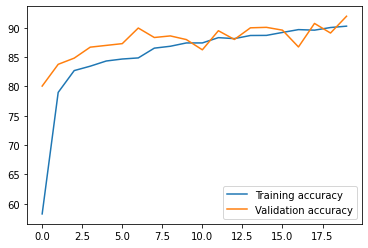

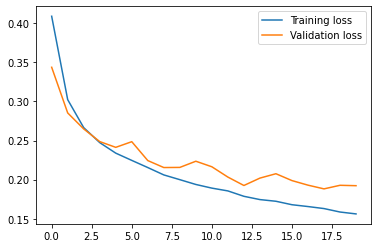

In [0]:
plotResults(trainacc_vgg_fc, validationacc_vgg_fc, trainloss_vgg_fc, validationloss_vgg_fc)

In [233]:
printResult(vgg16_1, trainloader, validationloader, batchSize)

Train Confusion Matrix : [[[6000    0]
  [ 109   91]]

 [[1936  264]
  [ 192 3808]]

 [[3797  204]
  [ 272 1928]]]
Validation Confusion Matrix : [[[600   0]
  [ 22   6]]

 [[190  38]
  [ 23 377]]

 [[383  18]
  [ 33 195]]]
F1 Score:  tensor(0.8966)
Train Accuracy:  90.88660378299944
Validation Accuracy:  88.8265234663743


In [0]:
printResult(vgg16_1, trainloader, testloader, batchSize)

Train Confusion Matrix : tensor([[  91,   16,   90],
        [   1, 3759,  163],
        [   0,  214, 1734]], dtype=torch.int32)
Validation Confusion Matrix : tensor([[  6,  10,  12],
        [  0, 378,  16],
        [  0,  24, 172]], dtype=torch.int32)
F1 Score:  tensor(0.8966)
Train Accuracy:  90.58719020734586
Validation Accuracy:  91.05136261238793


Experiment 2

In [0]:
vgg16_2 = models.vgg16(pretrained=True)
num_features = vgg16_2.classifier[0].in_features
vgg16_2.classifier[0] = nn.Linear(num_features, 4096)
vgg16_2.classifier[3] = nn.Linear(4096, 1000)
vgg16_2.classifier[6] = nn.Linear(1000, 3)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_2.load_state_dict(torch.load('/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/vgg16_experiment2', map_location=device))
trainacc_vgg16_2, validationacc_vgg16_2, trainloss_vgg16_2, validationloss_vgg16_2 = [], [], [], []

In [0]:
trainacc_vgg16_2, validationacc_vgg16_2, trainloss_vgg16_2, validationloss_vgg16_2, vgg16_2 = train(vgg16_2, 0.000000000005, 5, trainloader, testloader, trainacc_vgg16_2, validationacc_vgg16_2, trainloss_vgg16_2, validationloss_vgg16_2)

Epoch:  0  item:  56  total item:  6200


Epoch:  0  item:  12  total item:  628
Epoch:  0 	Training accuracy:  89.6750042304035 	Validation accuracy:  88.60079228452109 	Training loss:  0.1396348676199634 	Validation loss:  0.15037823181338372


Epoch:  1  item:  56  total item:  6200


Epoch:  1  item:  12  total item:  628
Epoch:  1 	Training accuracy:  90.54726542039313 	Validation accuracy:  88.25102096997219 	Training loss:  0.13861103277413114 	Validation loss:  0.16547395330468181


Epoch:  2  item:  56  total item:  6200


Epoch:  2  item:  12  total item:  628
Epoch:  2 	Training accuracy:  90.66364671383074 	Validation accuracy:  88.3341098657695 	Training loss:  0.1382741975267568 	Validation loss:  0.16657276601073848


Epoch:  3  item:  56  total item:  6200


Epoch:  3  item:  12  total item:  628
Epoch:  3 	Training accuracy:  90.21033295702118 	Validation accuracy:  88.9725444652095 	Training loss:  0.14029016358357282 	Validation loss:  0.15288709607093956


Epoch:  4  item:  56  total item:  6200


Epoch:  4  item:  12  total item:  628
Epoch:  4 	Training accuracy:  89.99135462501603 	Validation accuracy:  89.55908505486667 	Training loss:  0.141837342743191 	Validation loss:  0.1575586007563931


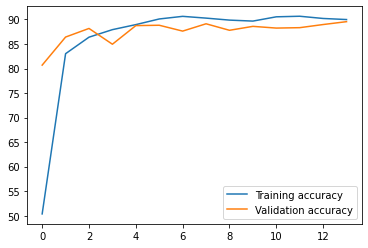

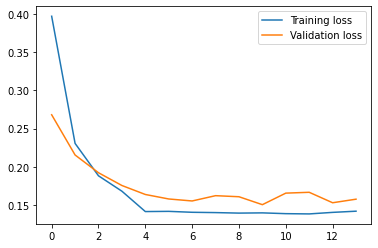

In [0]:
plotResults(trainacc_vgg_fc, validationacc_vgg_fc, trainloss_vgg_fc, validationloss_vgg_fc)

In [240]:
printResult(vgg16_2, trainloader, testloader, batchSize)

Train Confusion Matrix : [[[5998    2]
  [ 149   51]]

 [[1942  258]
  [ 158 3842]]

 [[3848  153]
  [ 257 1943]]]
Validation Confusion Matrix : [[[  0   0]
  [622   7]]

 [[211 418]
  [  0   0]]

 [[  0   1]
  [415 214]]]
F1 Score:  tensor(0.8966)
Train Accuracy:  90.16804317595314
Validation Accuracy:  1.8703920551055881


In [0]:
printResult(vgg16_2, trainloader, testloader, batchSize)

Train Confusion Matrix : tensor([[  54,   14,  128],
        [   0, 3810,  119],
        [   2,  216, 1726]], dtype=torch.int32)
Validation Confusion Matrix : tensor([[  4,   7,  14],
        [  0, 383,  11],
        [  0,  17, 175]], dtype=torch.int32)
F1 Score:  tensor(0.8966)
Train Accuracy:  89.75078770055727
Validation Accuracy:  92.51925500076092


In [0]:
torch.save(vgg16_2.state_dict(), '/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/vgg16_experiment2')

Experiment 3

In [0]:
resnet18_1 = models.resnet18(pretrained=True)
resnet18_1.fc = nn.Linear(in_features=512, out_features=3, bias=True)

In [242]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18_1.load_state_dict(torch.load('/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/vgg16_experiment3', map_location=device))

<All keys matched successfully>

In [0]:
trainacc_resnet18_1, validationacc_resnet18_1, trainloss_resnet18_1, validationloss_resnet18_1 = [], [], [], []

In [0]:
trainacc_resnet18_1, validationacc_resnet18_1, trainloss_resnet18_1, validationloss_resnet18_1, resnet18_1 = train(resnet18_1, 0.00009, 5, trainloader, testloader, trainacc_resnet18_1, validationacc_resnet18_1, trainloss_resnet18_1, validationloss_resnet18_1)

Epoch:  0  item:  56  total item:  6200


Epoch:  0  item:  12  total item:  628
Epoch:  0 	Training accuracy:  90.34965937427624 	Validation accuracy:  89.85320169802206 	Training loss:  0.14278479656144497 	Validation loss:  0.21364602482148037


Epoch:  1  item:  56  total item:  6200


Epoch:  1  item:  12  total item:  628
Epoch:  1 	Training accuracy:  90.96771626770288 	Validation accuracy:  88.53771738505799 	Training loss:  0.13353012079312918 	Validation loss:  0.2177940812792368


Epoch:  2  item:  56  total item:  6200


Epoch:  2  item:  12  total item:  628
Epoch:  2 	Training accuracy:  91.74525525228934 	Validation accuracy:  87.0578764452673 	Training loss:  0.12816549371687636 	Validation loss:  0.20314063634842064


Epoch:  3  item:  56  total item:  6200


Epoch:  3  item:  12  total item:  628
Epoch:  3 	Training accuracy:  92.51956973552248 	Validation accuracy:  89.48356950942777 	Training loss:  0.11555748159846951 	Validation loss:  0.19059705332063945


Epoch:  4  item:  56  total item:  6200


Epoch:  4  item:  12  total item:  628
Epoch:  4 	Training accuracy:  93.14569355314137 	Validation accuracy:  88.21369461969138 	Training loss:  0.11386857110165781 	Validation loss:  0.20619387991109472


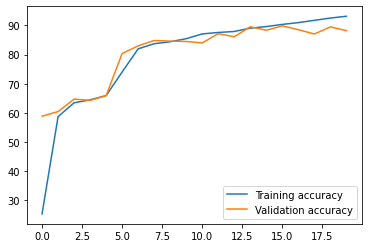

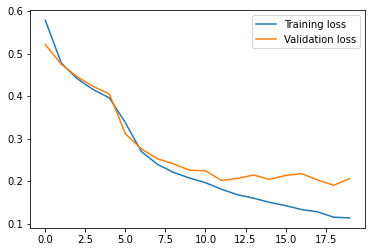

In [0]:
plotResults(trainacc_resnet18_1, validationacc_resnet18_1, trainloss_resnet18_1, validationloss_resnet18_1)

In [0]:
torch.save(resnet18_1.state_dict(), '/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/vgg16_experiment3')

In [243]:
resnet18_1.to(device)
printResult(resnet18_1, trainloader, testloader, batchSize)

Train Confusion Matrix : [[[5994    6]
  [  84  116]]

 [[2086  114]
  [  77 3923]]

 [[3926   75]
  [ 111 2089]]]
Validation Confusion Matrix : [[[  0   0]
  [612  17]]

 [[212 417]
  [  0   0]]

 [[  0   1]
  [418 211]]]
F1 Score:  tensor(0.8966)
Train Accuracy:  94.92612860570735
Validation Accuracy:  3.4755067232243877


In [0]:
resnet18_1.to(device)
printResult(resnet18_1, trainloader, testloader, batchSize)

Train Confusion Matrix : tensor([[ 115,    4,   80],
        [   0, 3925,   53],
        [   5,  108, 1864]], dtype=torch.int32)
Validation Confusion Matrix : tensor([[  7,   6,  13],
        [  0, 378,  16],
        [  0,  23, 176]], dtype=torch.int32)
F1 Score:  tensor(0.8966)
Train Accuracy:  95.46665147626187
Validation Accuracy:  92.00015724869836


# Focal Loss

In [0]:
resnet18_2 = models.resnet18(pretrained=True)
resnet18_2.fc = nn.Linear(in_features=512, out_features=3, bias=True)
trainacc_resnet18_2, validationacc_resnet18_2, trainloss_resnet18_2, validationloss_resnet18_2 = [], [], [], []

In [245]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18_2.load_state_dict(torch.load('/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/resnet18_2_experiment4', map_location=device))

<All keys matched successfully>

In [0]:
trainacc_resnet18_2, validationacc_resnet18_2, trainloss_resnet18_2, validationloss_resnet18_2, resnet18_2 = train(resnet18_2, 0.0001, 5, trainloader, validationloader,"FL", "SGD", batchSize, trainacc_resnet18_2, validationacc_resnet18_2, trainloss_resnet18_2, validationloss_resnet18_2)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Epoch:  0 	Training accuracy:  89.45270872586589 	Validation accuracy:  91.36622758818548 	Training loss:  0.03815422933909201 	Validation loss:  0.04779523620559911



Epoch:  1 	Training accuracy:  89.5927994012421 	Validation accuracy:  91.0957532008255 	Training loss:  0.03735978956063909 	Validation loss:  0.04546412982188972



Epoch:  2 	Training accuracy:  90.03902797766162 	Validation accuracy:  89.81590985383079 	Training loss:  0.03673734451013227 	Validation loss:  0.04809014489696284



Epoch:  3 	Training accuracy:  90.37603034091262 	Validation accuracy:  90.24944565422962 	Training loss:  0.036394224796564345 	Validation loss:  0.04851960991123679



Epoch:  4 	Training accuracy:  89.94600744252614 	Validation accuracy:  91.5725243431784 	Training loss:  0.035422241435416287 	Validation loss:  0.04464131755054377


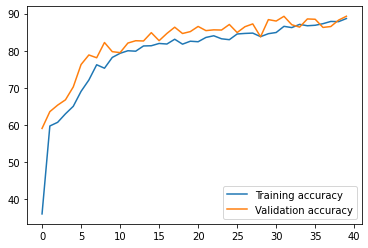

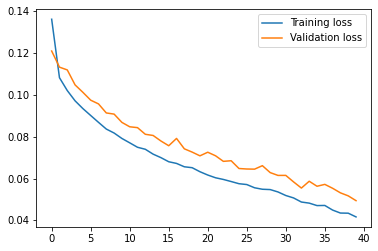

In [0]:
plotResults(trainacc_resnet18_2, validationacc_resnet18_2, trainloss_resnet18_2, validationloss_resnet18_2)

In [0]:
printResult(resnet18_2, trainloader, validationloader, batchSize)

Train Confusion Matrix : tensor([[ 125,   11,   59],
        [   0, 3780,  168],
        [   2,  251, 1702]], dtype=torch.int32)
Validation Confusion Matrix : tensor([[ 10,   6,  10],
        [  0, 373,  23],
        [  0,  26, 169]], dtype=torch.int32)
F1 Score:  tensor(0.8966)
Train Accuracy:  90.56833825183712
Validation Accuracy:  91.2949706563464


In [246]:
printResult(resnet18_2, trainloader, validationloader, batchSize)

Train Confusion Matrix : [[[5999    1]
  [  70  130]]

 [[1904  296]
  [ 192 3808]]

 [[3806  195]
  [ 307 1893]]]
Validation Confusion Matrix : [[[600   0]
  [ 18  10]]

 [[199  29]
  [ 22 378]]

 [[374  27]
  [ 32 196]]]
F1 Score:  tensor(0.8966)
Train Accuracy:  91.31185693951994
Validation Accuracy:  88.66981440221427


In [0]:
torch.save(resnet18_2.state_dict(), '/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/resnet18_2_experiment4')

Resnet18

In [184]:
resnet18_3 = models.resnet18(pretrained=True)
resnet18_3.fc = nn.Linear(in_features=512, out_features=3, bias=True)
trainacc_resnet18_3, validationacc_resnet18_3, trainloss_resnet18_3, validationloss_resnet18_3 = [], [], [], []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18_3.load_state_dict(torch.load('/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/resnet18_focal_loss', map_location=device))

<All keys matched successfully>

In [183]:
 trainacc_resnet18_3, validationacc_resnet18_3, trainloss_resnet18_3, validationloss_resnet18_3, resnet18_3 = train(resnet18_3, 0.00000005, 1, trainloader, validationloader,"FL", "Adam", batchSize ,trainacc_resnet18_3, validationacc_resnet18_3, trainloss_resnet18_3, validationloss_resnet18_3)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Epoch:  0 	Training accuracy:  90.4225445553153 	Validation accuracy:  94.3485839679376 	Training loss:  0.0354247604214376 	Validation loss:  0.041960783231600074


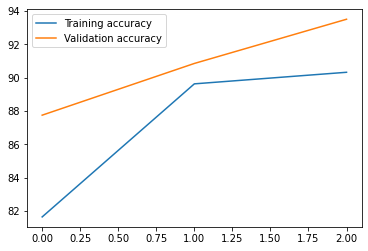

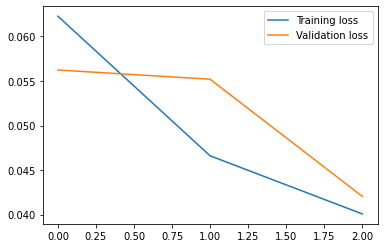

In [0]:
plotResults(trainacc_resnet18_3, validationacc_resnet18_3, trainloss_resnet18_3, validationloss_resnet18_3)

In [0]:
printResult(resnet18_3, trainloader, validationloader, batchSize)

Train Confusion Matrix : tensor([[ 149,   13,   36],
        [   2, 3867,  129],
        [  21,  233, 1744]], dtype=torch.int32)
Validation Confusion Matrix : tensor([[ 15,  10,   3],
        [  1, 380,  19],
        [  1,  25, 174]], dtype=torch.int32)
F1 Score:  tensor(0.8966)
Train Accuracy:  93.47383359994716
Validation Accuracy:  94.21009240233205


In [232]:
printResult(resnet18_3, trainloader, validationloader, batchSize)

Train Confusion Matrix : [[[5974   26]
  [  46  154]]

 [[1949  251]
  [ 134 3866]]

 [[3867  134]
  [ 249 1951]]]
Validation Confusion Matrix : [[[598   2]
  [ 11  17]]

 [[196  32]
  [ 12 388]]

 [[389  12]
  [ 32 196]]]
F1 Score:  tensor(0.8966)
Train Accuracy:  93.25762286014549
Validation Accuracy:  93.71931658937956


In [0]:
torch.save(resnet18_3.state_dict(), '/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/resnet18_focal_loss')

Focal loss VGG16

In [22]:
vgg16_3 = models.vgg16(pretrained=True)
num_features = vgg16_3.classifier[0].in_features
vgg16_3.classifier[0] = nn.Linear(num_features, 4096)
vgg16_3.classifier[3] = nn.Linear(4096, 1000)
vgg16_3.classifier[6] = nn.Linear(1000, 3)
trainacc_vgg16_3, validationacc_vgg16_3, trainloss_vgg16_3, validationloss_vgg16_3 = [], [], [], []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_3.load_state_dict(torch.load('/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/vgg16_focal_loss', map_location=device))

<All keys matched successfully>

In [0]:
trainacc_vgg16_3, validationacc_vgg16_3, trainloss_vgg16_3, validationloss_vgg16_3, vgg16_3 = train(vgg16_3, 0.00005, 5, trainloader, validationloader,"FL", "SGD", batchSize, trainacc_vgg16_3, validationacc_vgg16_3, trainloss_vgg16_3, validationloss_vgg16_3)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Epoch:  0 	Training accuracy:  90.84319855141413 	Validation accuracy:  90.19797563312953 	Training loss:  0.03312098444169087 	Validation loss:  0.041882417040171135



Epoch:  1 	Training accuracy:  91.07390006455022 	Validation accuracy:  92.04632718477177 	Training loss:  0.03268199235561394 	Validation loss:  0.03780585176246182



Epoch:  2 	Training accuracy:  90.72624711187942 	Validation accuracy:  93.18254080702552 	Training loss:  0.03214798388521998 	Validation loss:  0.03641664800323119



Epoch:  3 	Training accuracy:  91.01395786397671 	Validation accuracy:  92.90213189139587 	Training loss:  0.03133103978850188 	Validation loss:  0.03537887116526343



Epoch:  4 	Training accuracy:  91.21624081240171 	Validation accuracy:  90.69108979247035 	Training loss:  0.03175758930944627 	Validation loss:  0.03852739901086138


In [230]:
confusionMatrix(vgg16_3, trainloader)

array([[[5993,    7],
        [  65,  135]],

       [[1934,  266],
        [ 146, 3854]],

       [[3862,  139],
        [ 281, 1919]]])

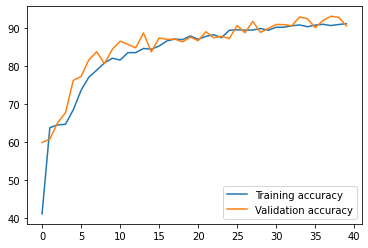

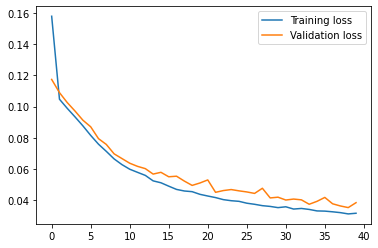

In [0]:
plotResults(trainacc_vgg16_3, validationacc_vgg16_3, trainloss_vgg16_3, validationloss_vgg16_3)

In [0]:
printResult(vgg16_3, trainloader, validationloader, batchSize)

Train Confusion Matrix : tensor([[ 132,   14,   51],
        [   0, 3828,  103],
        [   9,  218, 1691]], dtype=torch.int32)
Validation Confusion Matrix : tensor([[ 10,   6,   9],
        [  0, 378,  12],
        [  0,  17, 177]], dtype=torch.int32)
F1 Score:  tensor(0.8966)
Train Accuracy:  91.06789209708758
Validation Accuracy:  91.92509883816075


In [0]:
torch.save(vgg16_3.state_dict(), '/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/vgg16_focal_loss')

In [236]:
printResult(vgg16_3, trainloader, validationloader, batchSize)

Train Confusion Matrix : [[[5993    7]
  [  60  140]]

 [[1917  283]
  [ 139 3861]]

 [[3861  140]
  [ 276 1924]]]
Validation Confusion Matrix : [[[599   1]
  [ 16  12]]

 [[196  32]
  [ 12 388]]

 [[387  14]
  [ 33 195]]]
F1 Score:  tensor(0.8966)
Train Accuracy:  91.22491855668973
Validation Accuracy:  92.61418578426331


Testing

In [0]:
testpredictions = np.array(predict(resnet18_3, testloader, batchSize))

In [0]:
pd.DataFrame(testpredictions).to_csv('/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/assignment5_part2/results.csv', index=False, header=False)